In [1]:
import os
import pandas as pd

In [2]:
from numpy.random import normal

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
os.chdir(os.path.join(os.getcwd(),'../../..'))
import ExMAS.main
import ExMAS.utils
from ExMAS.transitize import *

In [5]:
import json
from ExMAS.utils import *

In [7]:
from ExMAS.transitize import visualizations
from ExMAS.transitize import analysis

In [8]:
params = ExMAS.utils.get_config('ExMAS/data/configs/transit.json')  # load the default

In [16]:
inData = ExMAS.utils.load_G(inData, params, stats=True)  # download the graph

In [18]:
inData.skims = DotMap(_dynamic=False)  # skim matrices of the network
inData.skims.dist = inData.skim.copy()  # distance (meters)
inData.skims.ride = inData.skims.dist.divide(params.speeds.ride).astype(int).T  # travel time (seconds)
inData.skims.walk = inData.skims.dist.divide(params.speeds.walk).astype(int).T  # walking time (seconds)

In [136]:
from ExMAS.main import init_log

In [137]:
inData.logger = init_log(params)

In [44]:
inData = analysis.load_results(PATH ='transit_results')
inData = analysis.determine_fares(inData, params)
inData.transitize.requests = analysis.PT_utility(inData.transitize.requests, params)

In [142]:
def stick_private_to_ms(inData, params):
    skim = inData.skims.walk
    rides = inData.transitize.rides
    rides.indexes_dest = rides.indexes_dest.apply(lambda x: json.loads(x) if type(x) == str else x)
    rides.indexes_orig = rides.indexes_orig.apply(lambda x: json.loads(x) if type(x)== str else x)
    
    requests = inData.transitize.requests
    to_be_sticked = rides[(rides.solution_3 == 1) & (rides.kind == 'p')]
    to_stick_to = rides[(rides.solution_3 == 1) & (rides.kind == 'ms')]
    ret = dict()
    for i in to_be_sticked.index: # loop for each private request
        request = requests.loc[i]
        best_to = np.inf  # find the best (shortest) multi-stop alternative
        solution_to = pd.Series({'ride':None, 'o':None, 'd':None, 'walk':None, 'ride':None, 'delay':None}) # output skeleton
        for j in to_stick_to.index:  # loop for ms rides to find the best one
            ms_ride = rides.loc[j]
            t = ExMAS.transitize.visualizations.make_schedule(ms_ride, rides)
            t.node = t.node.astype(int)
            t.times = ms_ride.times
            t['dep'] = t.apply(lambda x: t.times[:x.name].sum(),axis = 1)
            t['origin_walk'] = t.apply(lambda x: skim[x.node][request.origin], axis = 1)
            t['dest_walk'] = t.apply(lambda x: skim[request.destination][x.node], axis = 1)
            best = np.inf
            solution = pd.Series({'o':None, 'd':None, 'walk':None, 'ride':None, 'delay':None})
            for o in t.index:
                for d in t.index[o+1:]:                    
                        tt = t.loc[o].origin_walk+t.times[o+1:d+1].sum()+t.loc[d].dest_walk+abs(request.treq-(t.dep[o]-t.loc[o].origin_walk))
                        if tt<best:                            
                            best = tt
                            solution.o = o
                            solution.d = d
                            solution.walk = t.loc[o].origin_walk+t.loc[d].dest_walk
                            solution.ride = t.times[o+1:d+1].sum()
                            solution.delay = abs(request.treq - (t.dep[o] - t.loc[o].origin_walk))
            if solution.walk+solution.ride < best_to:
                best_to = solution.walk+solution.ride
                solution_to = solution
                solution.ride = j
            
        u_sticked = params.price * (1- params.multistop_discount) +
                    request.VoT * (params.walk_discomfort * solution.walk + solution.ride + params.delay_value * solution.delay)
        inData.logger.info('Request {} best sticked to ride {} with walk time {} ride time {} and delay {}'.format(i,j,solution.walk, solution.ride, solution.delay))
        if u_sticked < request.u_sh:
            inData.logger.info('\tAtractive {}>{}'.format(u_sticked, request.u_she))
            ret[i] = (j, o, d, u_sticked)
            jiji
        else:
            inData.logger.info('\tInatractive {}>{}'.format(u_sticked, request.u_sh))
    request['solution_4'] = requests.apply(lambda x: ret.get(x.name,x.solution_3))

stick_private_to_ms(inData, params)


26-10-21 23:26:49-INFO-Request 0 best sticked to ride 3411 with walk time 8717 ride time 296.0 and delay 2574.0
26-10-21 23:26:49-INFO-	Inatractive 42.3563>28.971603360824165
26-10-21 23:26:49-INFO-Request 2 best sticked to ride 3411 with walk time 9605 ride time 1369.0 and delay 3537.0
26-10-21 23:26:49-INFO-	Inatractive 53.2644>5.948470462263424
26-10-21 23:26:50-INFO-Request 3 best sticked to ride 3411 with walk time 6430 ride time 1369.0 and delay 1202.0
26-10-21 23:26:50-INFO-	Inatractive 32.3449>0.5329551616999552
26-10-21 23:26:50-INFO-Request 4 best sticked to ride 3411 with walk time 11207 ride time 1369.0 and delay 2971.0
26-10-21 23:26:50-INFO-	Inatractive 56.494200000000006>5.1034337043906435
26-10-21 23:26:50-INFO-Request 6 best sticked to ride 3411 with walk time 6534 ride time 1369.0 and delay 1094.0
26-10-21 23:26:50-INFO-	Inatractive 32.2553>0.4336547129661503
26-10-21 23:26:51-INFO-Request 10 best sticked to ride 3411 with walk time 6866 ride time 1369.0 and delay 151

KeyboardInterrupt: 

In [97]:
6310+5226+262

11798

In [13]:
inData = analysis.make_report(inData)
inData.transitize.report

,0,1,2,3
d2d,NaN,208.000000,155.000000,152.000000
dest_walk_time,0.000000,0.000000,24436.000000,25431.000000
fare,5635.867500,4768.285875,4399.332375,4278.941070
ms,NaN,NaN,NaN,15.000000
nRides,1000.000000,2068.000000,2160.000000,3530.000000
orig_walk_time,0.000000,0.000000,25381.000000,26634.000000
p,1000.000000,578.000000,582.000000,585.000000
s2s,NaN,NaN,53.000000,16.000000
test,1.000000,1.000000,1.000000,1.000000
ttrav,751062.000000,840961.000000,761718.200000,708310.400000


In [14]:
report = inData.transitize.report
report.columns = ['private','door-to-door pooled','stop-to-stop pooled','multi-stop pooled']
compos = report.loc[['p','d2d','s2s','ms']].fillna(0).astype(int).T
compos.columns = ['private','door-to-door pooled','stop-to-stop pooled','multi-stop pooled']
compos.index.name = 'solution'
compos.style.set_caption("Rides composition")

,private,door-to-door pooled,stop-to-stop pooled,multi-stop pooled
solution,,,,
private,1000,0,0,0
door-to-door pooled,578,208,0,0
stop-to-stop pooled,582,155,53,0
multi-stop pooled,585,152,16,15


In [15]:
pd.set_option('precision', 2)
KPIs = report.loc[['u_veh','u_pax','ttrav','orig_walk_time','dest_walk_time', 'nRides', 'fare', 'efficiency','occupancy']].fillna(0).T
for col in ['u_veh','ttrav', 'orig_walk_time', 'dest_walk_time']:
    KPIs[col] = (KPIs[col]/3600).round(2)
for col in ['u_pax','nRides', 'fare']:
    KPIs[col] = KPIs[col].astype(int)
for col in ['efficiency','occupancy']:
    KPIs[col] = KPIs[col].round(2)
KPIs.u_veh = KPIs.u_veh
KPIs.columns = ['vehicle hours','travellers costs (utility)','passenger in-vehicle hours',
                'walk time origin', 'walk time destination', 'feasible rides', 'total fare', 
                'fares per veh hours', 'occupancy']

KPIs.index.name = 'solution'
KPIs.style.set_caption("KPIs")

,vehicle hours,travellers costs (utility),passenger in-vehicle hours,walk time origin,walk time destination,feasible rides,total fare,fares per veh hours,occupancy
solution,,,,,,,,,
private,208.63,8239,208.63,0.00,0.00,1000,5635,27.01,1.00
door-to-door pooled,173.28,8065,233.60,0.00,0.00,2068,4768,27.52,1.35
stop-to-stop pooled,169.14,7735,211.59,7.05,6.79,2160,4399,26.01,1.25
multi-stop pooled,164.99,7426,196.75,7.40,7.06,3530,4278,25.93,1.19


In [17]:
requests = inData.transitize.requests
rm = inData.transitize.rm
requests['fare_3'] = requests.apply(lambda x: rm[(rm.ride==x.ride_solution_3) & (rm.traveller == x.name)].fare.max(), axis = 1)
requests['fare_2'] = requests.apply(lambda x: rm[(rm.ride==x.ride_solution_2) & (rm.traveller == x.name)].fare.max(), axis = 1)
requests['u_3'] = requests.apply(lambda x: rm[(rm.ride==x.ride_solution_3) & (rm.traveller == x.name)].u.max(), axis = 1)
requests['u_2'] = requests.apply(lambda x: rm[(rm.ride==x.ride_solution_2) & (rm.traveller == x.name)].u.max(), axis = 1)
requests['u_1'] = requests.apply(lambda x: rm[(rm.ride==x.ride_solution_1) & (rm.traveller == x.name)].u.max(), axis = 1)
requests['u_0'] = requests.apply(lambda x: rm[(rm.ride==x.ride_solution_1) & (rm.traveller == x.name)].u.max(), axis = 1)

In [18]:
rm[rm.traveller == 888]

,ride,traveller,degree,dist,ttrav,delay,u,orig_walk_time,dest_walk_time,VoT,...,destination,treq,kind,s2s_reference,door_departure,fare,solution_0,solution_1,solution_2,solution_3
"(888, 888)",888,888,1.0,4470,894.0,0.0,8.74,NaN,NaN,2.27e-03,...,46187377,847,p,NaN,NaN,6.71,1,1,1,1
"(1392, 888)",1392,888,2.0,4470,894.0,29.0,8.64,NaN,NaN,2.27e-03,...,46187377,847,d2d,NaN,NaN,5.03,0,0,0,0
"(2029, 888)",2029,888,2.0,4470,894.0,-7.5,8.10,NaN,NaN,2.27e-03,...,46187377,847,d2d,NaN,NaN,5.03,0,0,0,0


In [34]:
rides.loc[11065]

level_0                                                    490
index                                                      NaN
indexes                                   [888, 913, 917, 923]
indexes_orig                                    [10594, 10619]
indexes_dest                                    [10619, 10594]
u_pax                                                11.831393
u_veh                                                    672.5
kind                                                        ms
ttrav                                                      NaN
times                                 [2007.5, 128, 448.5, 96]
u_paxes                  [6.85163213445831, 4.979761030730403]
solution_0                                                   0
solution_1                                                   0
orig_walk_time                                           891.0
dest_walk_time                                          1174.0
low_level_indexes_set                                  

In [47]:
import seaborn as sns

In [14]:
inData.transitize.rm.tail()

,ride,traveller,degree,dist,ttrav,delay,u,orig_walk_time,dest_walk_time,VoT,...,destination,treq,kind,s2s_reference,door_departure,fare,solution_0,solution_1,solution_2,solution_3
910,12059,910,6.0,5276,711.625,643.0,8.262520,330.0,322.0,0.003128,...,1394126112,1701,ms,10591.0,2344.0,6.3312,0,0,0,0
856,12059,856,6.0,10942,2334.625,12.0,14.281914,317.0,182.0,0.003862,...,46503742,1607,ms,10617.0,1619.0,13.1304,0,0,0,0
828,12059,828,6.0,10935,2334.625,2.0,15.892001,358.0,310.0,0.004197,...,46507335,1576,ms,10617.0,1578.0,13.1220,0,0,0,0
988,12059,988,6.0,11376,1798.625,389.0,11.077188,0.0,295.0,0.002993,...,46486807,1838,ms,10620.0,2227.0,13.6512,0,0,0,0
622,12059,622,6.0,11271,1798.625,750.0,13.897531,323.0,0.0,0.003480,...,46489808,1154,ms,10620.0,1904.0,13.5252,0,0,0,0


In [22]:
rm = inData.transitize.rm
rm['u_private'] = rm.apply(lambda x: rm[(rm.kind=='p')& (rm.traveller == x.traveller)].u.max(), axis =1)

In [20]:
inData.transitize.rides['ttrav_total'] = inData.transitize.rides.apply(lambda x: inData.transitize.rm[inData.transitize.rm.ride == x.name].ttrav.sum(),axis = 1)

In [21]:
inData.transitize.rides['occupancy'] = inData.transitize.rides['ttrav_total'] / inData.transitize.rides['u_veh']

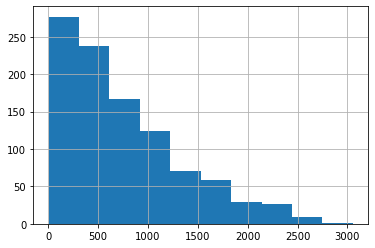

In [19]:
inData.transitize.requests.ttrav.hist()

In [24]:
import seaborn as sns

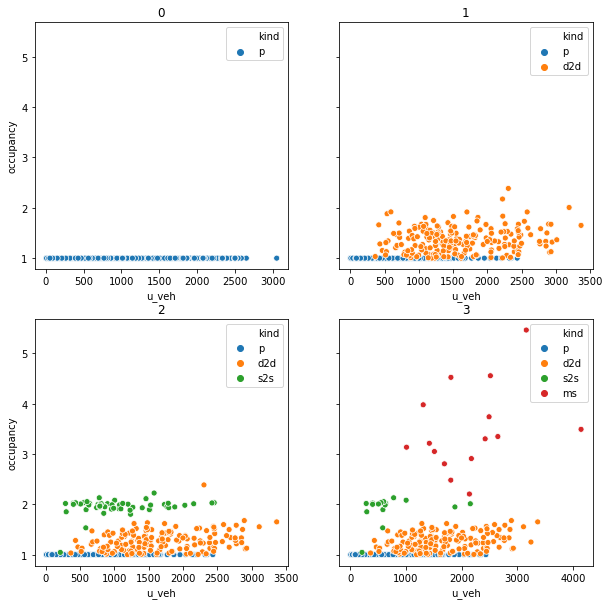

In [25]:
fig, ax = plt.subplots(2,2, figsize = (10,10), sharey = True)
ax = ax.flatten()
for level in [0,1,2,3]:
    solution = inData.transitize.rides[inData.transitize.rides['solution_{}'.format(level)] ==1]
    sns.scatterplot(data = solution, x = 'u_veh', y = 'occupancy', hue = 'kind' , ax = ax[level])
    ax[level].set_title(level)

In [26]:
rm['rel_dif'] = (rm.u - rm.u_private ) / rm.u

0.0
-15.837559749244912
-15.597388431651645
-37.5633336956265


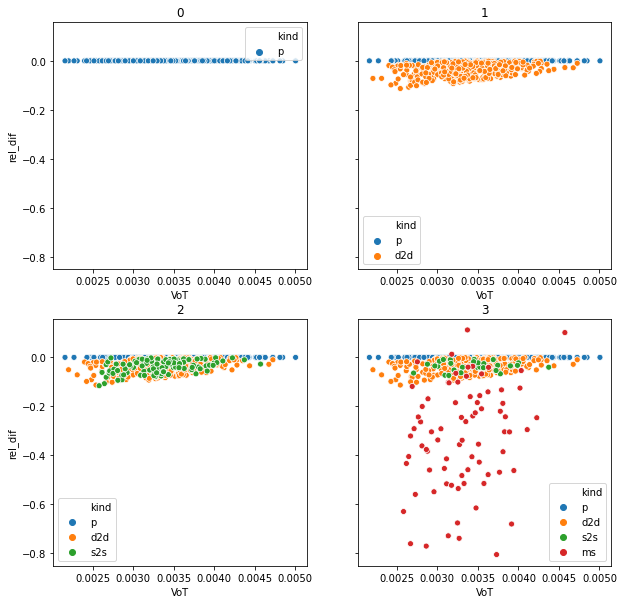

In [27]:
fig, ax = plt.subplots(2,2, figsize = (10,10), sharey = True)
ax = ax.flatten()
for level in [0,1,2,3]:
    solution = inData.transitize.rm[inData.transitize.rm['solution_{}'.format(level)] ==1]
    print(solution.rel_dif.sum())
    sns.scatterplot(data = solution, x = 'VoT', y = 'rel_dif', hue = 'kind' , ax = ax[level])
    ax[level].set_title(level)

In [28]:
inData = analysis.prep_results(PATH='transit_results', inData = inData, params = params)
inData = analysis.make_report(inData)
inData.transitize.report

KeyError: 'requests1'

In [15]:
inData.transitize.keys()

odict_keys(['rm', 'ridesExMAS2', 'rm1', 'rm3', 'rm2', 'requests', 'rides', 'report'])

In [128]:
rm = inData.transitize.rm
rm.sum()

ride                                                      254082000
traveller                                                   9960297
degree                                                     158026.0
dist                                                      262428524
ttrav                                                    40029703.0
delay                                                     7535422.0
u                                                     467303.596831
orig_walk_time                                            4224611.0
dest_walk_time                                            2856253.0
VoT                                                      123.255676
origin                                               40721312322618
destination                                          36741605653080
treq                                                       17575200
kind              pppppppppppppppppppppppppppppppppppppppppppppp...
s2s_reference                                   

In [113]:
inData.transitize.rides[(inData.transitize.rides.kind == 'ms') & (inData.transitize.rides.solution_3 == 1)]

,level_0,index,indexes,indexes_orig,indexes_dest,u_pax,u_veh,kind,ttrav,times,...,solution_1,orig_walk_time,dest_walk_time,low_level_indexes_set,origin,destination,d2d_reference,solution_2,high_level_indexes,solution_3
8575,217,NaN,"[401, 458, 426, 428]","[8400, 8380]","[8400, 8380]",7.499506,465.0,ms,NaN,"[1137.0, 144, 183, 138]",...,0,591.0,694.0,NaN,NaN,NaN,NaN,0,"[8400, 8380]",1
8602,244,NaN,"[111, 194, 85, 391]","[8385, 8360]","[8385, 8360]",10.633659,859.0,ms,NaN,"[823.0, 172, 95, 592]",...,0,904.0,953.0,NaN,NaN,NaN,NaN,0,"[8385, 8360]",1
10522,2164,NaN,"[340, 371, 295, 190, 198, 146, 23, 310]","[8375, 8372, 8392, 8382]","[8392, 8372, 8375, 8382]",57.627629,3014.0,ms,NaN,"[945.5, 47, 760, 545, 44, 160, 1037, 421]",...,0,2687.0,1586.0,NaN,NaN,NaN,NaN,0,"[8375, 8372, 8392, 8382]",1


In [133]:
rm[rm.ride == 10522]

,ride,traveller,degree,dist,ttrav,delay,u,orig_walk_time,dest_walk_time,VoT,...,destination,treq,kind,s2s_reference,door_departure,fare,solution_0,solution_1,solution_2,solution_3
295,10522,295,8.0,7955,1509.0,319.5,11.497792,193.0,134.0,0.003269,...,46269398,480,s2s,8372.0,799.5,7.87545,0,0,0,1
190,10522,190,8.0,8555,1509.0,343.5,11.020147,289.0,0.0,0.003034,...,46271757,360,s2s,8372.0,703.5,8.46945,0,0,0,1
340,10522,340,8.0,12544,2593.0,-48.5,16.361505,394.0,172.0,0.003263,...,4962112191,600,s2s,8375.0,551.5,12.41856,0,0,0,1
371,10522,371,8.0,12575,2593.0,-101.5,17.547267,387.0,382.0,0.003460,...,46460868,660,s2s,8375.0,558.5,12.44925,0,0,0,1
23,10522,23,8.0,9139,1662.0,1933.5,20.597456,364.0,336.0,0.003038,...,943758259,0,s2s,8382.0,1933.5,9.04761,0,0,0,1
310,10522,310,8.0,9060,1662.0,1417.5,24.532877,340.0,0.0,0.004630,...,46513364,540,s2s,8382.0,1957.5,8.96940,0,0,0,1
198,10522,198,8.0,4447,589.0,1067.5,12.859780,325.0,396.0,0.003657,...,46298410,360,s2s,8392.0,1427.5,4.40253,0,0,0,1
146,10522,146,8.0,4042,589.0,1057.5,10.814350,395.0,166.0,0.003226,...,46304945,300,s2s,8392.0,1357.5,4.00158,0,0,0,1


In [135]:
rm[(rm.kind=='p')&(rm.ride.isin(rm[rm.ride == 10522].traveller))]

,ride,traveller,degree,dist,ttrav,delay,u,orig_walk_time,dest_walk_time,VoT,...,destination,treq,kind,s2s_reference,door_departure,fare,solution_0,solution_1,solution_2,solution_3
"(23, 23)",23,23,1.0,9139,1142.0,0.0,17.178256,NaN,NaN,0.003038,...,943758259,0,p,NaN,NaN,13.7085,1,0,0,0
"(146, 146)",146,146,1.0,4042,505.0,0.0,7.692110,NaN,NaN,0.003226,...,46304945,300,p,NaN,NaN,6.0630,1,0,0,0
"(190, 190)",190,190,1.0,8555,1069.0,0.0,16.075548,NaN,NaN,0.003034,...,46271757,360,p,NaN,NaN,12.8325,1,0,0,0
"(198, 198)",198,198,1.0,4447,555.0,0.0,8.699927,NaN,NaN,0.003657,...,46298410,360,p,NaN,NaN,6.6705,1,0,0,0
"(295, 295)",295,295,1.0,7955,994.0,0.0,15.181956,NaN,NaN,0.003269,...,46269398,480,p,NaN,NaN,11.9325,1,0,0,0
"(310, 310)",310,310,1.0,9060,1132.0,0.0,18.830867,NaN,NaN,0.004630,...,46513364,540,p,NaN,NaN,13.5900,1,0,0,0
"(340, 340)",340,340,1.0,12544,1568.0,0.0,23.932010,NaN,NaN,0.003263,...,4962112191,600,p,NaN,NaN,18.8160,1,0,0,0
"(371, 371)",371,371,1.0,12575,1571.0,0.0,24.297596,NaN,NaN,0.003460,...,46460868,660,p,NaN,NaN,18.8625,1,0,0,0


In [94]:
inData.transitize.rides[inData.transitize.rides.kind=='ms'].shape

(2482, 22)

In [97]:
def calc_rm3(inData):
    def calc_deps(r):
        deps = [r.times[0]]
        for d in r.times[1:r.degree]:
            deps.append(deps[-1] + d)  # departure times
        return deps
    ret = list()
    for i,ms in inData.transitize.rides[inData.transitize.rides.kind=='ms'].iterrows():
        ms.degree = len(ms.indexes)
        ms['deps'] = calc_deps(ms)
        ms['indexes_orig'] = json.loads(ms['indexes_orig'])
        ms['indexes_dest'] = json.loads(ms['indexes_dest'])
        ms['high_level_indexes'] = json.loads(ms['high_level_indexes'])    
        df = rm[rm.ride.isin(ms.high_level_indexes)].copy()

        df['s2s_reference'] = df.ride.astype(int).copy()
        df['degree'] = len(ms.indexes)    
        df['ttrav'] = df.apply(lambda x: ms.deps[ms.indexes_dest.index(x.s2s_reference)+len(ms.high_level_indexes)] - ms.deps[ms.indexes_orig.index(x.s2s_reference)], axis = 1)
        df['door_departure'] = df.apply(lambda x: ms.deps[ms.indexes_orig.index(x.s2s_reference)] - x.orig_walk_time, axis = 1)
        df['delay'] = df.apply(lambda x: ms.deps[ms.indexes_orig.index(x.s2s_reference)] - x.orig_walk_time - x.treq, axis = 1)
        ret.append(df)
    df = pd.concat(ret)
    inData.transitize.rm = pd.concat([inData.transitize.rm,df])
    return inData
inData = calc_rm3(inData)

In [104]:
inData.transitize.rm

,ride,traveller,degree,dist,ttrav,delay,u,orig_walk_time,dest_walk_time,VoT,origin,destination,treq,kind,solution_0,solution_1,solution_2,solution_3
"(0, 0)",0,0,1.0,10936,1367,0.0,21.053871,NaN,NaN,0.003402,46456021,896347559,0,p,1,0,0,0
"(1, 1)",1,1,1.0,3684,460,0.0,6.918906,NaN,NaN,0.003028,46455322,2509134780,0,p,1,1,1,1
"(2, 2)",2,2,1.0,6145,768,0.0,11.826229,NaN,NaN,0.003397,943758259,3177151769,0,p,1,1,1,1
"(3, 3)",3,3,1.0,4192,524,0.0,7.885337,NaN,NaN,0.003048,46513163,46478086,0,p,1,0,0,0
"(4, 4)",4,4,1.0,8905,1113,0.0,17.663974,NaN,NaN,0.003869,46551890,46428320,0,p,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
153,8407,153,NaN,4985,585,18.0,9.677839,198.0,166.0,0.004577,46282613,46286728,300,s2s,0,0,0,0
282,8407,282,NaN,4885,585,4.0,9.423835,100.0,0.0,0.004150,46275938,46294316,420,s2s,0,0,0,0
153,8408,153,NaN,4985,585,18.0,10.166919,198.0,166.0,0.004577,46282613,46286728,300,s2s,0,0,1,0
282,8408,282,NaN,4885,585,4.0,9.583509,100.0,0.0,0.004150,46275938,46294316,420,s2s,0,0,1,0


In [32]:
ms = inData.transitize.rides.loc[10522]
ms

level_0                                                               2164
index                                                                  NaN
indexes                            [340, 371, 295, 190, 198, 146, 23, 310]
indexes_orig                                      [8375, 8372, 8392, 8382]
indexes_dest                                      [8392, 8372, 8375, 8382]
u_pax                                                            57.627629
u_veh                                                               3014.0
kind                                                                    ms
ttrav                                                                  NaN
times                            [945.5, 47, 760, 545, 44, 160, 1037, 421]
u_paxes                  [21.84009411764706, 13.726270588235293, 6.2666...
solution_0                                                               0
solution_1                                                               0
orig_walk_time           

In [39]:
nodes = list(inData.transitize.rides.loc[json.loads(ms.indexes_orig)].origin.astype(int).values) + list(inData.transitize.rides.loc[json.loads(ms.indexes_dest)].destination.astype(int).values)

In [43]:
for i, node in enumerate(nodes[:-1]):
    print(int(nx.shortest_path_length(inData.G, node, nodes[i+1], weight='length')/params.avg_speed))

47
760
545
44
160
1037
421


In [29]:
params = ExMAS.utils.get_config('ExMAS/data/configs/transit.json')  # load the default
inData = ExMAS.utils.load_G(inData, params, stats=True)  # download the graph

In [102]:
inData.transitize.rm

,ride,traveller,degree,dist,ttrav,delay,u,orig_walk_time,dest_walk_time
"(0, 0)",0,0,1.0,10936,1367,0.0,21.053871,NaN,NaN
"(1, 1)",1,1,1.0,3684,460,0.0,6.918906,NaN,NaN
"(2, 2)",2,2,1.0,6145,768,0.0,11.826229,NaN,NaN
"(3, 3)",3,3,1.0,4192,524,0.0,7.885337,NaN,NaN
"(4, 4)",4,4,1.0,8905,1113,0.0,17.663974,NaN,NaN
...,...,...,...,...,...,...,...,...,...
153,8407,153,NaN,4985,585,18.0,9.677839,198.0,166.0
282,8407,282,NaN,4885,585,4.0,9.423835,100.0,0.0
153,8408,153,NaN,4985,585,18.0,10.166919,198.0,166.0
282,8408,282,NaN,4885,585,4.0,9.583509,100.0,0.0


In [97]:
inData.transitize.rides

,level_0,index,indexes,indexes_orig,indexes_dest,u_pax,u_veh,kind,ttrav,times,...,solution_1,orig_walk_time,dest_walk_time,low_level_indexes_set,origin,destination,d2d_reference,solution_2,high_level_indexes,solution_3
0,0,0.0,[0],[0],[0],21.053871,1367.0,p,1367.0,"[0, 1367]",...,0,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,0
1,1,1.0,[1],[1],[1],6.918906,460.0,p,460.0,"[0, 460]",...,1,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,1
2,2,2.0,[2],[2],[2],11.826229,768.0,p,768.0,"[0, 768]",...,1,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,1
3,3,3.0,[3],[3],[3],7.885337,524.0,p,524.0,"[0, 524]",...,0,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,0
4,4,4.0,[4],[4],[4],17.663974,1113.0,p,1113.0,"[0, 1113]",...,0,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10886,2528,NaN,"[371, 340, 295, 190, 198, 146, 23, 310]","[8397, 8393, 8369, 8382]","[8369, 8393, 8397, 8382]",57.926012,3019.0,ms,NaN,"[945.5, 47, 760, 545, 54, 155, 1037, 421]",...,0,2687.0,1546.0,NaN,NaN,NaN,NaN,0,"[8397, 8393, 8369, 8382]",0
10887,2529,NaN,"[371, 340, 295, 190, 428, 426, 85, 391]","[8397, 8393, 8402, 8360]","[8402, 8393, 8360, 8397]",48.987929,2834.0,ms,NaN,"[945.5, 47, 418, 306, 98, 597, 590, 778]",...,0,2154.0,1754.0,NaN,NaN,NaN,NaN,0,"[8397, 8393, 8402, 8360]",0
10888,2530,NaN,"[371, 340, 295, 190, 401, 458, 428, 426]","[8397, 8393, 8378, 8402]","[8378, 8402, 8393, 8397]",41.976671,2597.0,ms,NaN,"[945.5, 47, 451, 144, 183, 138, 597, 1037]",...,0,1854.0,1382.0,NaN,NaN,NaN,NaN,0,"[8397, 8393, 8378, 8402]",0
10889,2531,NaN,"[371, 340, 295, 190, 401, 458, 426, 428]","[8397, 8393, 8378, 8380]","[8378, 8380, 8393, 8397]",41.976671,2597.0,ms,NaN,"[945.5, 47, 451, 144, 183, 138, 597, 1037]",...,0,1854.0,1382.0,NaN,NaN,NaN,NaN,0,"[8397, 8393, 8378, 8380]",0


In [88]:
nx.shortest_path_length(inData.G, 46444472, 46418110, weight='length')/params.avg_speed

632.5120000000002

In [103]:
inData.transitize.rm.sum()

ride                                                      104563912
traveller                                                   5744376
degree                                                      59500.0
dist                                                      154639461
ttrav                                                      19319049
delay                                                      740867.0
u                                                     282176.288739
orig_walk_time                                              22713.0
dest_walk_time                                              18823.0
VoT                                                       70.937764
origin                                               21201667381222
destination                                          27600155116941
treq                                                       10109880
kind              pppppppppppppppppppppppppppppppppppppppppppppp...
solution_0                                      

In [90]:
inData.transitize.rides[inData.transitize.rides.kind=='s2s']

,level_0,index,indexes,indexes_orig,indexes_dest,u_pax,u_veh,kind,ttrav,times,...,solution_1,orig_walk_time,dest_walk_time,low_level_indexes_set,origin,destination,d2d_reference,solution_2,high_level_indexes,solution_3
6987,6987,1311.0,"[109, 182]",NaN,NaN,15.248252,731.0,s2s,731.0,"[659, 731]",...,0,414.0,436.0,"{109, 182}",46444472.0,46418110.0,1311.0,0,NaN,0
6988,6988,1757.0,"[182, 109]",NaN,NaN,15.248252,731.0,s2s,731.0,"[659, 731]",...,0,414.0,436.0,"{109, 182}",46444472.0,46418110.0,1757.0,0,NaN,0
6989,6989,3506.0,"[109, 182]",NaN,NaN,15.248252,731.0,s2s,731.0,"[659, 731]",...,0,414.0,436.0,"{109, 182}",46444472.0,46418110.0,3506.0,0,NaN,0
6990,6990,3785.0,"[182, 109]",NaN,NaN,15.248252,731.0,s2s,731.0,"[659, 731]",...,0,414.0,436.0,"{109, 182}",46444472.0,46418110.0,3785.0,0,NaN,0


In [99]:
solutions = dict()
solution = requests.copy()

solution['u_veh'.format(level)] = solution.apply(lambda x: rides.loc[x.ride_solution_3].u_veh,axis=1)
solution['u_veh'.format(level)] = solution.apply(lambda x: rides.loc[x.ride_solution_3].u_veh,axis=1)

In [67]:
rides.sample()

,level_0,index,indexes,indexes_orig,indexes_dest,u_pax,u_veh,kind,ttrav,orig_walk_time,dest_walk_time,solution_0,solution_1,low_level_indexes_set,origin,destination,d2d_reference,solution_2,high_level_indexes,solution_3
2047,2047,2047.0,"[114, 321]","[114, 321]","[114, 321]",18.541249,1028.0,d2d,1456.0,0.0,0.0,0,1,NaN,NaN,NaN,NaN,1,NaN,1


In [41]:
requests[requests.ride_solution_2==501]

,index,origin,destination,treq,tarr,ttrav,dist,ttrav_alb,pax_id,VoT,delta,u,u_PT,ride_id,ttrav_sh,u_sh,kind,position,ride_solution_2
0,4107740,46535164,46478055,0,2021-06-16 17:15:00,428,3431,0 days 00:15:00.000000000,4107740,0.003038,227.032977,6.446665,999999,501,439,5.901559,20,0,501
175,4152267,46515549,46453900,300,2021-06-16 17:16:00,715,5724,0 days 00:11:00.000000000,4152267,0.003297,335.782240,10.943462,999999,501,806,10.228584,20,1,501


In [77]:
rides[rides.solution_3==1]

,level_0,index,indexes,indexes_orig,indexes_dest,u_pax,u_veh,kind,ttrav,orig_walk_time,dest_walk_time,solution_0,solution_1,low_level_indexes_set,origin,destination,d2d_reference,solution_2,high_level_indexes,solution_3
0,0,0.0,[0],[0],[0],6.812829,428.0,p,428.0,0.0,0.0,1,1,NaN,NaN,NaN,NaN,1,NaN,1
2,2,2.0,[2],[2],[2],7.200701,477.0,p,477.0,0.0,0.0,1,1,NaN,NaN,NaN,NaN,1,NaN,1
6,6,6.0,[6],[6],[6],7.862792,502.0,p,502.0,0.0,0.0,1,1,NaN,NaN,NaN,NaN,1,NaN,1
8,8,8.0,[8],[8],[8],6.568949,424.0,p,424.0,0.0,0.0,1,1,NaN,NaN,NaN,NaN,1,NaN,1
9,9,9.0,[9],[9],[9],4.284738,280.0,p,280.0,0.0,0.0,1,1,NaN,NaN,NaN,NaN,1,NaN,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21856,21856,5486.0,"[638, 679]",NaN,NaN,11.417550,451.0,s2s,451.0,508.0,415.0,0,0,"{638, 679}",6.930975e+09,46301087.0,5486.0,0,NaN,1
21864,21864,6869.0,"[185, 427]",NaN,NaN,12.010488,556.0,s2s,556.0,198.0,436.0,0,0,"{185, 427}",3.296690e+09,46349235.0,6869.0,0,NaN,1
21901,26,NaN,"[669, 670]",[21857],[21857],8.075000,580.0,ms,580.0,545.0,203.0,0,0,NaN,NaN,NaN,NaN,0,[21857],1
21903,28,NaN,"[603, 683]",[21872],[21872],4.321000,320.0,ms,320.0,355.0,346.0,0,0,NaN,NaN,NaN,NaN,0,[21872],1


In [79]:
inData.transitize.rm1

,Unnamed: 1,ride,traveller,shared,degree,treq,ride_time,dist,ttrav,ttrav_sh,delay,u,u_sh,exp_u_private,exp_u_d2d,sum_exp
0,0,0,0,False,1,0,428,3431,428,428,0.0,6.812829,6.812829,0.129529,0.129529,0.259058
1,1,1,1,False,1,0,1367,10936,1367,1367,0.0,22.392218,22.392218,0.001209,0.001209,0.002419
2,2,2,2,False,1,0,477,3823,477,477,0.0,7.200701,7.200701,0.115301,0.115301,0.230602
3,3,3,3,False,1,0,1309,10473,1309,1309,0.0,19.582024,19.582024,0.002810,0.002810,0.005620
4,4,4,4,False,1,0,524,4192,524,524,0.0,7.579945,7.579945,0.102901,0.102901,0.205803
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21843,274,21843,274,True,6,360,2161,8023,1002,1377,218.0,14.935107,14.666253,0.011327,0.012279,0.023606
21843,484,21843,484,True,6,600,2161,8546,1068,1592,18.0,16.569937,15.773442,0.006936,0.008809,0.015745
21843,407,21843,407,True,6,480,2161,8748,1093,1987,256.0,16.825488,16.757162,0.006424,0.006557,0.012982
21843,437,21843,437,True,6,540,2161,4756,594,1317,353.0,8.664569,8.605097,0.074320,0.075658,0.149979


In [93]:
inData.transitize.rm2

,ride,exp_u_private,exp_u_d2d,sum_exp,u,u_sh,origin,destination,dist,VoT,orig_walk_time,delay,dest_walk_time,s2s_ttrav,u_s2s,exp_u_s2s,prob_s2s,efficient,pax_id,ride_s2s
61,1430,0.263537,0.286908,0.930616,4.445199,4.161974,4625767491,2613311559,2348,0.003151,150.0,15.0,55.0,319,3.223792,0.380170,-0.895229,True,61,"Int64Index([], dtype='int64')"
129,1430,0.292103,0.313951,1.049644,4.102164,3.861726,4625767495,46421701,2217,0.002804,0.0,15.0,125.0,319,2.709512,0.443590,-0.861305,True,129,"Int64Index([], dtype='int64')"
75,1539,0.044689,0.056301,0.190590,10.360070,9.590135,6932947315,46189775,5314,0.003598,278.0,92.0,106.0,734,8.041364,0.089599,-0.754776,True,75,"Int64Index([], dtype='int64')"
186,1539,0.054180,0.062441,0.213097,9.718130,9.245122,46291028,4623486333,4919,0.003810,283.0,93.0,5.0,734,7.794882,0.096476,-0.792455,True,186,"Int64Index([], dtype='int64')"
86,1725,0.042087,0.042095,0.152472,10.560032,10.559387,46477674,46332009,5474,0.003434,263.0,157.0,282.0,771,8.946684,0.068289,-0.803230,True,86,"Int64Index([], dtype='int64')"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
683,8712,0.273992,0.303740,0.941335,4.315527,3.971946,46477293,1587126037,2214,0.003603,134.0,17.0,46.0,320,3.372302,0.363604,-0.951235,True,683,"Int64Index([], dtype='int64')"
638,8771,0.128617,0.129331,0.431643,6.836383,6.817921,46289604,46290160,3527,0.003513,276.0,8.0,274.0,451,5.834860,0.173694,-0.910302,True,638,"Int64Index([], dtype='int64')"
679,8771,0.116440,0.145652,0.449436,7.167938,6.421792,5191247973,46306367,3620,0.003845,232.0,8.0,141.0,451,5.582690,0.187344,-0.875044,True,679,"Int64Index([], dtype='int64')"
669,8804,0.055631,0.061039,0.243800,9.630056,9.320825,46431377,7027339018,4814,0.004008,300.0,28.0,5.0,580,6.875136,0.127131,-0.651134,True,669,"Int64Index([], dtype='int64')"


In [95]:
#inData.transitize.rm2['ride_s2s'] = inData.transitize.rm2.apply(lambda x: rides[(rides.d2d_reference == x.ride) & (rides.kind == 's2s')].index[0],axis =1)
inData.transitize.rm2

,ride,exp_u_private,exp_u_d2d,sum_exp,u,u_sh,origin,destination,dist,VoT,orig_walk_time,delay,dest_walk_time,s2s_ttrav,u_s2s,exp_u_s2s,prob_s2s,efficient,pax_id,ride_s2s
61,1430,0.263537,0.286908,0.930616,4.445199,4.161974,4625767491,2613311559,2348,0.003151,150.0,15.0,55.0,319,3.223792,0.380170,-0.895229,True,61,"Int64Index([], dtype='int64')"
129,1430,0.292103,0.313951,1.049644,4.102164,3.861726,4625767495,46421701,2217,0.002804,0.0,15.0,125.0,319,2.709512,0.443590,-0.861305,True,129,"Int64Index([], dtype='int64')"
75,1539,0.044689,0.056301,0.190590,10.360070,9.590135,6932947315,46189775,5314,0.003598,278.0,92.0,106.0,734,8.041364,0.089599,-0.754776,True,75,"Int64Index([], dtype='int64')"
186,1539,0.054180,0.062441,0.213097,9.718130,9.245122,46291028,4623486333,4919,0.003810,283.0,93.0,5.0,734,7.794882,0.096476,-0.792455,True,186,"Int64Index([], dtype='int64')"
86,1725,0.042087,0.042095,0.152472,10.560032,10.559387,46477674,46332009,5474,0.003434,263.0,157.0,282.0,771,8.946684,0.068289,-0.803230,True,86,"Int64Index([], dtype='int64')"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
683,8712,0.273992,0.303740,0.941335,4.315527,3.971946,46477293,1587126037,2214,0.003603,134.0,17.0,46.0,320,3.372302,0.363604,-0.951235,True,683,"Int64Index([], dtype='int64')"
638,8771,0.128617,0.129331,0.431643,6.836383,6.817921,46289604,46290160,3527,0.003513,276.0,8.0,274.0,451,5.834860,0.173694,-0.910302,True,638,"Int64Index([], dtype='int64')"
679,8771,0.116440,0.145652,0.449436,7.167938,6.421792,5191247973,46306367,3620,0.003845,232.0,8.0,141.0,451,5.582690,0.187344,-0.875044,True,679,"Int64Index([], dtype='int64')"
669,8804,0.055631,0.061039,0.243800,9.630056,9.320825,46431377,7027339018,4814,0.004008,300.0,28.0,5.0,580,6.875136,0.127131,-0.651134,True,669,"Int64Index([], dtype='int64')"


In [113]:
rides[rides.kind=='ms']

,level_0,index,indexes,indexes_orig,indexes_dest,u_pax,u_veh,kind,ttrav,times,...,dest_walk_time,solution_0,solution_1,low_level_indexes_set,origin,destination,d2d_reference,solution_2,high_level_indexes,solution_3
14994,45,NaN,"[168, 288, 290, 426]","[14957, 14965]","[14957, 14965]",19.905976,1669.0,ms,1814.0,"[397.0, 644, 45, 980]",...,570.0,0,0,NaN,NaN,NaN,NaN,0,"[14957, 14965]",0
14995,46,NaN,"[168, 288, 426, 290]","[14957, 14967]","[14957, 14967]",19.905976,1669.0,ms,1814.0,"[397.0, 644, 45, 980]",...,570.0,0,0,NaN,NaN,NaN,NaN,0,"[14957, 14967]",0
14996,47,NaN,"[168, 288, 290, 426]","[14957, 14986]","[14957, 14986]",19.905976,1669.0,ms,1814.0,"[397.0, 644, 45, 980]",...,570.0,0,0,NaN,NaN,NaN,NaN,0,"[14957, 14986]",0
14997,48,NaN,"[168, 288, 426, 290]","[14957, 14988]","[14957, 14988]",19.905976,1669.0,ms,1814.0,"[397.0, 644, 45, 980]",...,570.0,0,0,NaN,NaN,NaN,NaN,0,"[14957, 14988]",0
14998,49,NaN,"[168, 288, 290, 426]","[14979, 14965]","[14979, 14965]",19.905976,1669.0,ms,1814.0,"[397.0, 644, 45, 980]",...,570.0,0,0,NaN,NaN,NaN,NaN,0,"[14979, 14965]",0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15703,754,NaN,"[276, 609, 497, 462, 216, 274, 168, 288]","[14984, 14990, 14981, 14957]","[14984, 14981, 14990, 14957]",39.365994,2092.0,ms,2923.0,"[883.0, 212, 177, 571, 72, 123, 674, 263]",...,1337.0,0,0,NaN,NaN,NaN,NaN,0,"[14984, 14990, 14981, 14957]",0
15704,755,NaN,"[276, 609, 497, 462, 216, 274, 168, 288]","[14984, 14990, 14960, 14979]","[14984, 14960, 14990, 14979]",39.365994,2092.0,ms,2923.0,"[883.0, 212, 177, 571, 72, 123, 674, 263]",...,1337.0,0,0,NaN,NaN,NaN,NaN,0,"[14984, 14990, 14960, 14979]",0
15705,756,NaN,"[276, 609, 497, 462, 216, 274, 168, 288]","[14984, 14990, 14960, 14957]","[14984, 14960, 14990, 14957]",39.365994,2092.0,ms,2923.0,"[883.0, 212, 177, 571, 72, 123, 674, 263]",...,1337.0,0,0,NaN,NaN,NaN,NaN,0,"[14984, 14990, 14960, 14957]",0
15706,757,NaN,"[276, 609, 497, 462, 274, 216, 168, 288]","[14984, 14990, 14963, 14979]","[14984, 14963, 14990, 14979]",39.365994,2092.0,ms,2923.0,"[883.0, 212, 177, 571, 72, 123, 674, 263]",...,1337.0,0,0,NaN,NaN,NaN,NaN,0,"[14984, 14990, 14963, 14979]",0


In [102]:
inData.transitize.rm2.ride.unique

,ride,exp_u_private,exp_u_d2d,sum_exp,u,u_sh,origin,destination,dist,VoT,orig_walk_time,delay,dest_walk_time,s2s_ttrav,u_s2s,exp_u_s2s,prob_s2s,efficient,pax_id
3,734,0.048195,0.053456,0.199226,10.108332,9.763017,46495864,46364819,5142,0.003731,158.0,155.0,82.0,688,7.757087,0.097576,-0.713812,True,3
155,734,0.042734,0.054860,0.194795,10.509176,9.676558,46502424,6129443325,5490,0.003315,228.0,155.0,135.0,688,7.769936,0.097200,-0.695173,True,155
4,744,0.084873,0.092650,0.308402,8.222001,7.929764,46513163,46478086,4192,0.003691,182.0,1.0,243.0,639,6.778269,0.130879,-0.857129,True,4
122,744,0.072204,0.078117,0.308682,8.760869,8.498501,46515660,46466007,4427,0.003834,0.0,1.0,181.0,639,6.142915,0.158362,-0.667432,True,122
44,1174,0.044349,0.056238,0.194587,10.385548,9.593896,46447128,46395415,5377,0.003452,300.0,33.0,270.0,667,7.881522,0.094000,-0.727581,True,44
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
645,7835,0.245949,0.278167,0.860360,4.675441,4.265113,1416317596,1582704842,2391,0.003654,147.0,7.0,32.0,362,3.633059,0.336244,-0.939513,True,645
574,7859,0.104082,0.120690,0.426200,7.541911,7.048420,3657588020,46418359,3997,0.003099,0.0,20.0,300.0,565,5.341096,0.201427,-0.749481,True,574
488,7859,0.113797,0.129243,0.412414,7.244456,6.820206,1223057257,46435212,3667,0.003808,161.0,21.0,135.0,565,5.918814,0.169374,-0.889918,True,488
695,8032,0.205892,0.219417,0.730200,5.268018,5.055940,46322722,46250042,2710,0.003559,205.0,5.0,42.0,361,3.959335,0.304891,-0.873363,True,695


In [110]:
inData.transitize.rm1

,Unnamed: 1,ride,traveller,shared,degree,treq,ride_time,dist,ttrav,ttrav_sh,delay,u,u_sh,exp_u_private,exp_u_d2d,sum_exp
0,0,0,0,False,1,0,428,3431,428,428,0.0,6.779218,6.779218,0.130842,0.130842,0.261684
1,1,1,1,False,1,0,1140,9125,1140,1140,0.0,17.896882,17.896882,0.004658,0.004658,0.009317
2,2,2,2,False,1,0,1309,10473,1309,1309,0.0,21.256081,21.256081,0.001701,0.001701,0.003401
3,3,3,3,False,1,0,642,5142,642,642,0.0,10.108332,10.108332,0.048195,0.048195,0.096390
4,4,4,4,False,1,0,524,4192,524,524,0.0,8.222001,8.222001,0.084873,0.084873,0.169746
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14948,520,14948,520,True,5,660,2677,11182,1397,1835,-59.0,20.439142,19.503221,0.002173,0.002877,0.005050
14948,568,14948,568,True,5,720,2677,8886,1110,1657,59.0,16.444944,16.121741,0.007201,0.007935,0.015136
14948,503,14948,503,True,5,600,2677,5002,625,1521,315.0,9.496440,9.210529,0.057906,0.063092,0.120998
14948,535,14948,535,True,5,660,2677,11622,1452,2235,383.0,21.872922,20.394567,0.001413,0.002202,0.003615


In [107]:
rides = inData.transitize.rides
rides[rides.kind=='s2s']

,level_0,index,indexes,indexes_orig,indexes_dest,u_pax,u_veh,kind,ttrav,times,...,dest_walk_time,solution_0,solution_1,low_level_indexes_set,origin,destination,d2d_reference,solution_2,high_level_indexes,solution_3
14949,14949,734.0,"[3, 155]",NaN,NaN,15.527024,688.0,s2s,688.0,"[539, 688]",...,217.0,0,0,"{3, 155}",4.649650e+07,4.636248e+07,734.0,0,NaN,0
14950,14950,744.0,"[4, 122]",NaN,NaN,12.921184,639.0,s2s,639.0,"[479, 639]",...,424.0,0,0,"{122, 4}",4.651566e+07,3.886313e+09,744.0,0,NaN,0
14951,14951,1174.0,"[44, 208]",NaN,NaN,14.259437,667.0,s2s,667.0,"[599, 667]",...,330.0,0,0,"{208, 44}",4.645228e+07,4.638548e+07,1174.0,0,NaN,0
14952,14952,1377.0,"[71, 76]",NaN,NaN,11.580395,517.0,s2s,517.0,"[359, 517]",...,415.0,0,0,"{76, 71}",4.639562e+07,4.632061e+07,1377.0,1,NaN,0
14953,14953,1437.0,"[76, 71]",NaN,NaN,11.580395,517.0,s2s,517.0,"[359, 517]",...,415.0,0,0,"{76, 71}",4.639562e+07,4.632061e+07,1437.0,0,NaN,0
14954,14954,1939.0,"[122, 4]",NaN,NaN,12.921184,639.0,s2s,639.0,"[479, 639]",...,424.0,0,0,"{122, 4}",4.651566e+07,3.886313e+09,1939.0,0,NaN,0
14955,14955,2186.0,"[142, 383]",NaN,NaN,16.685421,780.0,s2s,780.0,"[659, 780]",...,208.0,0,0,"{142, 383}",7.125956e+09,7.191482e+09,2186.0,0,NaN,0
14956,14956,2321.0,"[155, 3]",NaN,NaN,15.527024,688.0,s2s,688.0,"[539, 688]",...,217.0,0,0,"{3, 155}",4.649650e+07,4.636248e+07,2321.0,0,NaN,0
14957,14957,2408.0,"[168, 288]",NaN,NaN,16.405998,731.0,s2s,731.0,"[659, 731]",...,436.0,0,0,"{168, 288}",4.644447e+07,4.641811e+07,2408.0,0,NaN,0
14958,14958,2557.0,"[189, 466]",NaN,NaN,17.295892,788.0,s2s,788.0,"[839, 788]",...,420.0,0,0,"{466, 189}",4.638564e+07,2.882581e+09,2557.0,0,NaN,0


In [81]:
pd.concat([inData.transitize.rm1,inData.transitize.rm2])

,Unnamed: 1,ride,traveller,shared,degree,treq,ride_time,dist,ttrav,ttrav_sh,...,destination,VoT,orig_walk_time,dest_walk_time,s2s_ttrav,u_s2s,exp_u_s2s,prob_s2s,efficient,pax_id
0,0.0,0,0.0,False,1.0,0.0,428.0,3431,428.0,428.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,1,1.0,False,1.0,0.0,1367.0,10936,1367.0,1367.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2.0,2,2.0,False,1.0,0.0,477.0,3823,477.0,477.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3.0,3,3.0,False,1.0,0.0,1309.0,10473,1309.0,1309.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4.0,4,4.0,False,1.0,0.0,524.0,4192,524.0,524.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
683,NaN,8712,NaN,NaN,NaN,NaN,NaN,2214,NaN,NaN,...,1.587126e+09,0.003603,134.0,46.0,320.0,3.372302,0.363604,-0.951235,True,683.0
638,NaN,8771,NaN,NaN,NaN,NaN,NaN,3527,NaN,NaN,...,4.629016e+07,0.003513,276.0,274.0,451.0,5.834860,0.173694,-0.910302,True,638.0
679,NaN,8771,NaN,NaN,NaN,NaN,NaN,3620,NaN,NaN,...,4.630637e+07,0.003845,232.0,141.0,451.0,5.582690,0.187344,-0.875044,True,679.0
669,NaN,8804,NaN,NaN,NaN,NaN,NaN,4814,NaN,NaN,...,7.027339e+09,0.004008,300.0,5.0,580.0,6.875136,0.127131,-0.651134,True,669.0


In [100]:
rides = inData.transitize.rides
requests = inData.transitize.requests

In [22]:
level = 2


In [ ]:
 = requests.apply(lambda x: )

In [15]:
inData.transitize.ExMASrides1.shape, inData.transitize.ridesExMAS2.shape

((8281, 12), (2428, 11))

In [43]:
ride

level_0                                            818
index                                              NaN
indexes                  [245, 273, 62, 158, 240, 430]
indexes_orig                        [8297, 8309, 8296]
indexes_dest                        [8297, 8296, 8309]
u_pax                                        21.843824
u_veh                                           1415.0
kind                                                ms
ttrav                                           1835.0
orig_walk_time                                  1466.0
dest_walk_time                                  1016.0
solution_0                                           0
solution_1                                           0
low_level_indexes_set                              NaN
origin                                             NaN
destination                                        NaN
d2d_reference                                      NaN
solution_2                                           0
high_level

[295677789,
 46296981,
 6932947315,
 46291028,
 46316327,
 46305753,
 297095265,
 46380540,
 46189775,
 4623486333,
 6960846027,
 46360198]

In [50]:
ride_index = 9149
rides = inData.transitize.rides
requests = inData.transitize.requests

ride = inData.transitize.rides.loc[ride_index]
try:
    ride['high_level_indexes'] = json.loads(ride['high_level_indexes'])
except:
    pass
ride['origins'] = requests.loc[ride.indexes].origin.values
ride['destinations'] = requests.loc[ride.indexes].destination.values

private_rides = rides[rides.kind=='p'][rides['index'].isin(ride.indexes)]

s2s_rides = rides.loc[ride.high_level_indexes]

d2d_rides = rides.loc[s2s_rides.d2d_reference.values]

In [54]:
private_rides

,level_0,index,indexes,indexes_orig,indexes_dest,u_pax,u_veh,kind,ttrav,orig_walk_time,dest_walk_time,solution_0,solution_1,low_level_indexes_set,origin,destination,d2d_reference,solution_2,high_level_indexes,solution_3
62,62,62.0,[62],[62],[62],9.923126,664.0,p,664.0,0.0,0.0,1,0,NaN,NaN,NaN,NaN,0,NaN,0
158,158,158.0,[158],[158],[158],9.899972,614.0,p,614.0,0.0,0.0,1,0,NaN,NaN,NaN,NaN,0,NaN,0
240,240,240.0,[240],[240],[240],5.666961,361.0,p,361.0,0.0,0.0,1,0,NaN,NaN,NaN,NaN,0,NaN,0
245,245,245.0,[245],[245],[245],8.830251,547.0,p,547.0,0.0,0.0,1,0,NaN,NaN,NaN,NaN,0,NaN,0
273,273,273.0,[273],[273],[273],10.626044,683.0,p,683.0,0.0,0.0,1,0,NaN,NaN,NaN,NaN,0,NaN,0
430,430,430.0,[430],[430],[430],5.388863,341.0,p,341.0,0.0,0.0,1,0,NaN,NaN,NaN,NaN,0,NaN,0


In [55]:
d2d_rides

,level_0,index,indexes,indexes_orig,indexes_dest,u_pax,u_veh,kind,ttrav,orig_walk_time,dest_walk_time,solution_0,solution_1,low_level_indexes_set,origin,destination,d2d_reference,solution_2,high_level_indexes,solution_3
2124.0,2124,2124.0,"[245, 273]","[245, 273]","[245, 273]",18.217090,762.0,d2d,1336.0,0.0,0.0,0,0,NaN,NaN,NaN,NaN,0,NaN,0
3286.0,3286,3286.0,"[62, 158]","[62, 158]","[158, 62]",18.052043,714.0,d2d,1345.0,0.0,0.0,0,0,NaN,NaN,NaN,NaN,0,NaN,0
2107.0,2107,2107.0,"[240, 430]","[240, 430]","[240, 430]",10.968870,421.0,d2d,751.0,0.0,0.0,0,1,NaN,NaN,NaN,NaN,1,NaN,0


In [56]:
s2s_rides

,level_0,index,indexes,indexes_orig,indexes_dest,u_pax,u_veh,kind,ttrav,orig_walk_time,dest_walk_time,solution_0,solution_1,low_level_indexes_set,origin,destination,d2d_reference,solution_2,high_level_indexes,solution_3
8297,8297,2124.0,"[245, 273]",NaN,NaN,17.201110,670.0,s2s,670.0,538.0,746.0,0,0,"{273, 245}",4.629682e+07,4.638422e+07,2124.0,1,NaN,0
8309,8309,3286.0,"[62, 158]",NaN,NaN,14.610193,727.0,s2s,727.0,557.0,111.0,0,0,"{158, 62}",7.026678e+09,4.619043e+07,3286.0,0,NaN,0
8296,8296,2107.0,"[240, 430]",NaN,NaN,9.508813,438.0,s2s,438.0,371.0,159.0,0,0,"{240, 430}",4.630716e+07,6.960846e+09,2107.0,0,NaN,0


In [16]:
rides = inData.transitize.rides
rides[(rides.solution_3==1)&(rides.kind=='ms')]

,level_0,index,indexes,indexes_orig,indexes_dest,u_pax,u_veh,kind,ttrav,orig_walk_time,dest_walk_time,solution_0,solution_1,low_level_indexes_set,origin,destination,d2d_reference,solution_2,high_level_indexes,solution_3
8354,23,NaN,"[336, 337]",[8301],[8301],6.902500,494.0,ms,494.0,764.0,312.0,0,0,NaN,NaN,NaN,NaN,0,[8301],1
8357,26,NaN,"[362, 206]",[8325],[8325],4.718000,277.0,ms,277.0,156.0,381.0,0,0,NaN,NaN,NaN,NaN,0,[8325],1
8418,87,NaN,"[72, 368, 156, 271]","[8284, 8314]","[8284, 8314]",18.195359,1240.0,ms,1537.0,754.0,902.0,0,0,NaN,NaN,NaN,NaN,0,"[8284, 8314]",1
8451,120,NaN,"[68, 60, 187, 388]","[8310, 8317]","[8310, 8317]",12.527712,733.0,ms,1060.0,1269.0,1126.0,0,0,NaN,NaN,NaN,NaN,0,"[8310, 8317]",1
8691,360,NaN,"[305, 366, 212, 173]","[8300, 8319]","[8300, 8319]",13.039365,810.0,ms,1244.0,1132.0,901.0,0,0,NaN,NaN,NaN,NaN,0,"[8300, 8319]",1
8951,620,NaN,"[157, 363, 358, 393]","[8315, 8303]","[8303, 8315]",9.567771,675.0,ms,894.0,892.0,599.0,0,0,NaN,NaN,NaN,NaN,0,"[8315, 8303]",1
9149,818,NaN,"[245, 273, 62, 158, 240, 430]","[8297, 8309, 8296]","[8297, 8296, 8309]",21.843824,1415.0,ms,1835.0,1466.0,1016.0,0,0,NaN,NaN,NaN,NaN,0,"[8297, 8309, 8296]",1
